Generate segmentation for fluorescent and brightfield data

In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']='2'

import sys
sys.path.append('/gpfs/hpc/home/papkov/universal-segmenter/')  
sys.path.append('../scripts/')            

import modellib
import uniseg

In [21]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from itertools import cycle
from PIL import Image

## Metadata

In [6]:
img_dir = '/gpfs/hpc/home/etais/com_palo/2017-08-21_7CellLines_Confocal+BF/images/'
seg_dir = '/gpfs/hpc/home/etais/com_palo/2017-08-21_7CellLines_Confocal+BF/StencilsNuclei/'

In [7]:
import xml.etree.ElementTree as ET
import re

def replace_well(match):
    g1 = match.group(1)
    g2 = match.group(2)
    return '%02d%02d' % (ord(g1) - 64, int(g2))

metainfo = [['{}K1F{}P1'.format(re.sub(r'^([A-Z])(\d{1,2})$', replace_well, entry[2].text), entry[3].text), 
             entry[7].text] for entry in ET.parse("/gpfs/hpc/home/papkov/pe-cell-line/Index.xml").getroot()]
metainfo = pd.DataFrame(metainfo, columns=['name', 'line'])
metainfo.head()

,name,line
0,0110K1F1P1,HeLa
1,0111K1F1P1,MCF7
2,0112K1F1P1,MCF7
3,0113K1F1P1,MCF7
4,0114K1F1P1,A549


## Data

In [ ]:
def data_reader(metainfo, cell_line='all', modality='bf', read_segmentation=False, s=1080):
    modality_postfix = {'bf': 'R2', 'fl': 'R1', 'br': 'R2'}
    postfix = modality_postfix[modality.lower()[:2]]
    
    img_dir = '/gpfs/hpc/home/etais/com_palo/2017-08-21_7CellLines_Confocal+BF/images/'
    seg_dir = '/gpfs/hpc/home/etais/com_palo/2017-08-21_7CellLines_Confocal+BF/StencilsNuclei/'
    
    # Filter one particular cell line
    if cell_line != 'all':
        assert cell_line in metainfo.line.unique()
        metainfo = metainfo[metainfo.line == cell_line]
        
    n = len(metainfo)
    imgs = np.zeros((n, s, s), dtype=np.uint8)
    if read_segmentation:
        segs = np.zeros((n, s, s), dtype=np.uint8)
    
    for i, fn in enumerate(metainfo.name):
        print('\rreading {} {}/{}'.format(fn, i+1, n), end='', sep='')
        img = Image.open('{}/{}{}.png'.format(img_dir, fn, postfix))
        img = np.array(img, dtype=np.float32)
        # Normalize
        img -= img.min()
        img /= img.max()
        img *= 255
        img = img.astype(np.uint8)
        # Append
        imgs[i] = img
        
        if read_segmentation:
            seg = Image.open('{}/{}R1.png'.format(seg_dir, fn))
            seg = np.array(seg, dtype=np.uint8)
            seg[seg > 0] = 1
            segs[i] = seg
            
    print()
    if read_segmentation:
        imgs = (imgs, segs)
    return imgs

In [38]:
def data_generator(metainfo, batch_size=4, patch_size=288, cell_line='all', shuffle=False, modality='bf', seed=43):
    np.random.seed(seed)
    
    modality_postfix = {'bf': 'R2', 'fl': 'R1', 'br': 'R2'}
    postfix = modality_postfix[modality.lower()[:2]]
    
    img_dir = '/gpfs/hpc/home/etais/com_palo/2017-08-21_7CellLines_Confocal+BF/images/'
    seg_dir = '/gpfs/hpc/home/etais/com_palo/2017-08-21_7CellLines_Confocal+BF/StencilsNuclei/'
    
    assert patch_size <= 1080
    
    # Filter one particular cell line
    if cell_line != 'all':
        assert cell_line in metainfo.line.unique()
        metainfo = metainfo[metainfo.line == cell_line]
        
    # Create an iterable of names
    fnames = np.array(metainfo.name)
    if shuffle:
        np.random.shuffle(fnames)
    fnames = cycle(fnames)
        
    while True:
        
        x = np.zeros((batch_size, patch_size, patch_size, 1), dtype=np.float32) 
        y = np.zeros((batch_size, patch_size, patch_size, 1), dtype=np.uint8)
        
        # Generate a batch
        for i in range(batch_size):
            # Read next image
            fn = next(fnames)
            img = Image.open('{}/{}{}.png'.format(img_dir, fn, postfix))
            img = np.array(img, dtype=np.float32)
            
            seg = Image.open('{}/{}R1.png'.format(seg_dir, fn))
            seg = np.array(seg, dtype=np.uint8)
            
            # TODO Normalization (currently between 0 and 1)
            img -= img.min()
            img /= img.max()
            
            img *= 255
            img = img.astype(np.uint8)
            
            # All stencils are 1
            seg[seg > 0] = 1
            
            # Crop a patch
            if patch_size != img.shape[0] and patch_size != 0:
                a, b = np.random.choice(img.shape[0]-patch_size, 2)
                img = img[a:a+patch_size, b:b+patch_size]
                seg = seg[a:a+patch_size, b:b+patch_size]
            
            # Add to a batch
            x[i], y[i] = np.expand_dims(img, -1), np.expand_dims(seg, -1)
        
        yield x, y

In [11]:
def test_data_generator(data_generator, max_plot=8):
    t = time.time()
    
    batch_x, batch_y = next(data_generator)
    nrows = 2
    if len(batch_y) == 2:
        batch_y, batch_y_2 = batch_y
        nrows = 3
        
    t = time.time() - t
    
    fig, ax = plt.subplots(ncols=min(max_plot, batch_x.shape[0]), nrows=nrows, figsize=(3*min(max_plot, batch_x.shape[0]), 3*nrows))
    for i in range(len(batch_x)):
        if i == max_plot: break
        ax[0, i].imshow(batch_x[i].squeeze())
        ax[1, i].imshow(batch_y[i].squeeze())
        if nrows == 3:
            ax[2, i].imshow(batch_y_2[i].squeeze())
    plt.setp(ax, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()
    
    return t

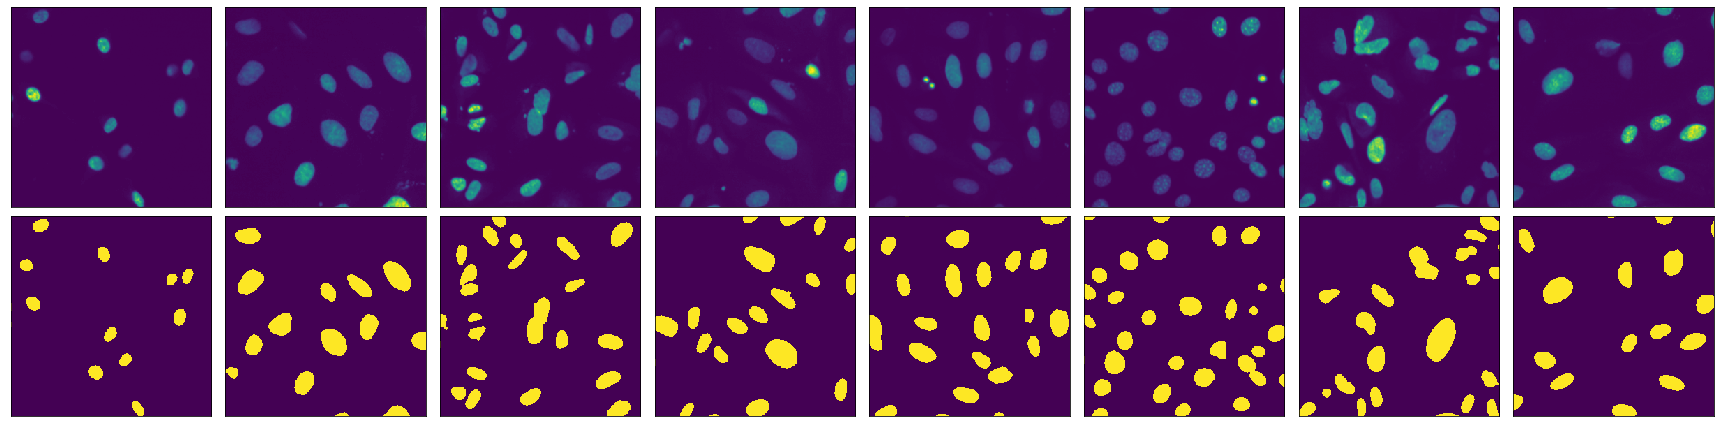

1.0723307132720947

In [39]:
generator_fl = data_generator(metainfo, shuffle=True, batch_size=12, modality='fluo')
test_data_generator(generator_fl)

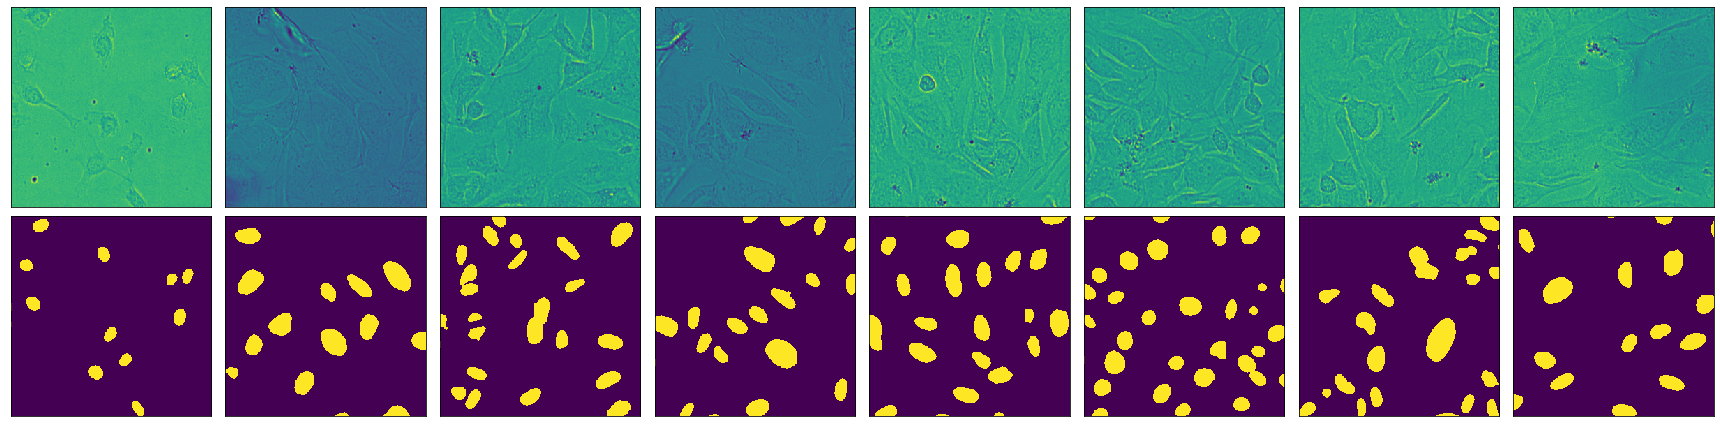

1.060210943222046

In [40]:
generator_bf = data_generator(metainfo, shuffle=True, batch_size=12, modality='bf')
test_data_generator(generator_bf)

## U-Net++

Load ant test models (check adequacy of outputs)

In [50]:
def test_model(model, generator):
    x, y = next(generator)
    preds = uniseg.utils.predict.pred_imgs(model=model, img_data=x)

    plt.imshow(preds[0].squeeze() > 0.5)
    plt.axis('off')
    plt.show()

    print(x.shape, y.shape)
    print('Acc: {:.3f}, Pr: {:.3f}, Rc: {:.3f}, F1: {:.3f}'.format(*uniseg.utils.metrics.aprf(preds.squeeze() > 0.5, y.squeeze())))

### Fluorescent

In [45]:
model_fl = modellib.get_Nest_Net(img_rows=288, img_cols=288, color_type=1, num_class=1, deep_supervision=False, lr=3e-4)
model_fl.load_weights(os.path.join('../models', 'model_fl.hdf5'))

Tensor("main_input_1:0", shape=(?, 288, 288, 1), dtype=float32)


100%|██████████| 12/12 [00:00<00:00, 19.48it/s]


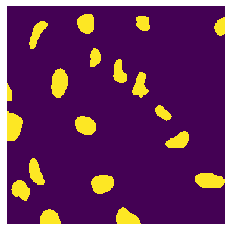

(12, 288, 288, 1) (12, 288, 288, 1)
Acc: 0.995, Pr: 0.993, Rc: 0.953, F1: 0.973


In [48]:
test_model(model_fl, generator_fl)

### Brightfield

In [49]:
model_bf = modellib.get_Nest_Net(img_rows=288, img_cols=288, color_type=1, num_class=1, deep_supervision=False, lr=1e-2)
model_bf.load_weights(os.path.join('../models', 'model_bf.hdf5'))

Tensor("main_input_2:0", shape=(?, 288, 288, 1), dtype=float32)


100%|██████████| 12/12 [00:01<00:00,  7.84it/s]


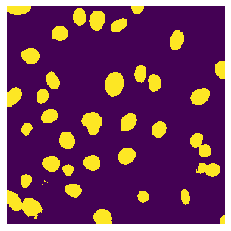

(12, 288, 288, 1) (12, 288, 288, 1)
Acc: 0.946, Pr: 0.789, Rc: 0.820, F1: 0.804


In [51]:
test_model(model_bf, generator_bf)

## Create data

In [66]:
def get_stack(cell_line, model_fl, model_bf):
    fl = data_reader(metainfo, cell_line=cell_line, modality='fl')
    bf = data_reader(metainfo, cell_line=cell_line, modality='bf')
    fl_seg = uniseg.utils.predict.pred_imgs(model=model_fl, img_data=fl, batch_size=16).squeeze() 
    bf_seg = uniseg.utils.predict.pred_imgs(model=model_bf, img_data=bf, batch_size=16).squeeze()
    return {'fl': fl, 'bf': bf, 'fl_seg': fl_seg, 'bf_seg': bf_seg}

In [82]:
%%time
stack = get_stack('HepG2', model_fl=model_fl, model_bf=model_bf)

reading 1619K1F9P1 432/432

100%|██████████| 432/432 [01:52<00:00,  3.84it/s]

CPU times: user 3min 33s, sys: 1min 25s, total: 4min 58s
Wall time: 5min


In [83]:
np.savez('../data/HepG2.npz', **stack)

In [84]:
def show_some_from_stack(stack, i=0):
    fig, axes = plt.subplots(ncols=4, figsize=(24,6))
    for ax, (k, v), t in zip(axes, stack.items(), 
                             ['Fluorescent', 'Brightfield', 'Fluorescent (GT) segmentation', 'Brightfield segmentation']):
        ax.imshow(v[i].squeeze())
        ax.set_title(t)
    plt.setp(axes, xticks=[], yticks=[])
    plt.tight_layout()
    plt.show()
    
    # Metrics
    x = stack['fl_seg'][i].squeeze() > 0.5
    y = stack['bf_seg'][i].squeeze() > 0.5
    aprf = uniseg.utils.metrics.aprf(x, y)
    ow_f1 = uniseg.utils.metrics.ow_score(x, y, 'f1')
    print('Acc: {:.3f}, Pr: {:.3f}, Rc: {:.3f}, F1: {:.3f}, OW-F1: {:.3f}'.format(*aprf, ow_f1))

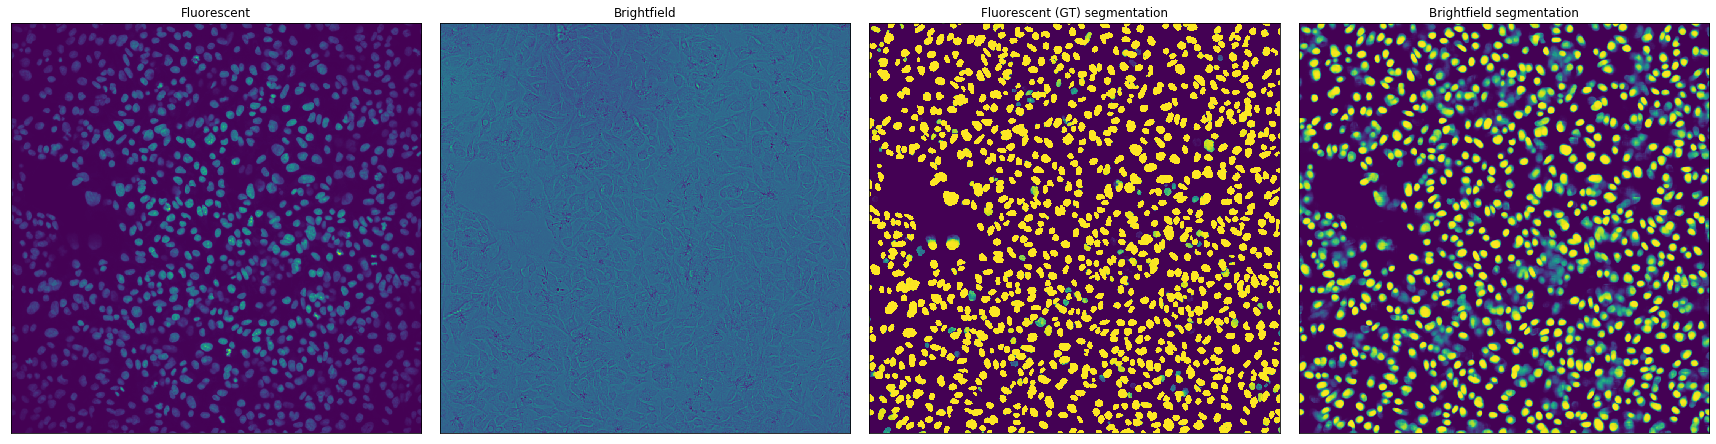

Acc: 0.871, Pr: 0.825, Rc: 0.700, F1: 0.757, OW-F1: 0.314


In [85]:
show_some_from_stack(stack, 50)